Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
start = time.time()

In [2]:
import pandas as pd, numpy as np, gc
from datetime import datetime
import joblib

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import cudf, cupy, time
cudf.__version__

startNB = time.time()

In [3]:
from numba import jit, njit, prange
from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(gt, pred, nafill=True):
    if nafill:
        pred[ np.isnan(pred) ] = np.nanmean( pred )
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

@njit
def numba_log_loss(y,x):
    n = x.shape[0]
    ll = 0.
    for i in prange(n):
        if y[i]<=0.:
            ll += np.log(1-x[i] + 1e-15 )
        else:
            ll += np.log(x[i] + 1e-15)
    return -ll / n

def compute_rce(gt , pred, nafill=True, verbose=0):
    if nafill:
        pred[ np.isnan(pred) ] = np.nanmean( pred )
        
    cross_entropy = numba_log_loss( gt, pred  )
    
    yt = np.mean(gt>0)     
    strawman_cross_entropy = -(yt*np.log(yt) + (1 - yt)*np.log(1 - yt))
    
    if verbose:
        print( "logloss: {0:.5f} / {1:.5f} = {2:.5f}".format(cross_entropy, strawman_cross_entropy, cross_entropy/strawman_cross_entropy))
        print( 'mean:    {0:.5f} / {1:.5f}'.format( np.nanmean( pred ) , yt  ) )
    
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [4]:
def save_memory( df ):
    features = df.columns
    for i in range( df.shape[1] ):
        if df.dtypes[i] == 'uint8':
            df[features[i]] = df[features[i]].astype( np.int8 )
            gc.collect()
        elif df.dtypes[i] == 'bool':
            df[features[i]] = df[features[i]].astype( np.int8 )
            gc.collect()
        elif df.dtypes[i] == 'uint32':
            df[features[i]] = df[features[i]].astype( np.int32 )
            gc.collect()
        elif df.dtypes[i] == 'int64':
            df[features[i]] = df[features[i]].astype( np.int32 )
            gc.collect()
        elif df.dtypes[i] == 'float64':
            df[features[i]] = df[features[i]].astype( np.float32 )
            gc.collect()
    

# Load Train

In [5]:
TARGET_id = 1

TARGETS = ['reply', 'retweet', 'retweet_comment', 'like']

TARGET = TARGETS[TARGET_id]

train = pd.read_parquet( 'data/train-final-te-'+TARGET+'-1.parquet' )
gc.collect()

4

In [6]:
train['a_follower_count']  = train.groupby('a_user_id')['a_follower_count' ].transform('last');_ = gc.collect()
train['a_following_count'] = train.groupby('a_user_id')['a_following_count'].transform('last');_ = gc.collect()
train['b_follower_count']  = train.groupby('b_user_id')['a_follower_count' ].transform('last');_ = gc.collect()
train['b_following_count'] = train.groupby('b_user_id')['a_following_count'].transform('last');_ = gc.collect()

In [7]:
train.tail()

,hashtags,tweet_id,media,links,domains,tweet_type,language,timestamp,a_user_id,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_user_id,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a,reply,retweet,retweet_comment,like,id,tr,dt_day,dt_dow,dt_hour,a_count_combined,a_user_fer_count_delta_time,a_user_fing_count_delta_time,a_user_fering_count_delta_time,a_user_fing_count_mode,a_user_fer_count_mode,a_user_fering_count_mode,count_ats,count_char,count_words,tw_hash,tw_freq_hash,tw_first_word,tw_second_word,tw_last_word,tw_llast_word,tw_len,tw_hash0,tw_hash1,tw_rt_uhash,TE_b_user_id_tweet_type_language_retweet,TE_tw_first_word_tweet_type_language_retweet,TE_tw_last_word_tweet_type_language_retweet,TE_tw_hash0_tweet_type_language_retweet,TE_tw_hash1_tweet_type_language_retweet,TE_tw_rt_uhash_tweet_type_language_retweet,TE_a_user_id_retweet,TE_b_user_id_retweet,TE_tw_hash_retweet,TE_tw_freq_hash_retweet,TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_retweet,TE_a_count_combined_tweet_type_language_retweet,TE_a_user_fer_count_delta_time_media_language_retweet,TE_a_user_fing_count_delta_time_media_language_retweet,TE_a_user_fering_count_delta_time_tweet_type_language_retweet,TE_a_user_fing_count_mode_media_language_retweet,TE_a_user_fer_count_mode_media_language_retweet,TE_a_user_fering_count_mode_tweet_type_language_retweet,TE_domains_media_tweet_type_language_retweet,TE_links_media_tweet_type_language_retweet,TE_hashtags_media_tweet_type_language_retweet
146255999,0,73443134,0,0,0,1,59,1582081341,1362744,5390,833,0,1546658592,30848700,5390,833,0,1428007228,0,0,0,0,0,146255999,2,19,2,3,2,1,1,1,1,1,1,0,76,15,39170347,34858164,28651,210319,2793,27536,6,0,0,7739,NaN,0.242062,0.196108,0.157438,0.149134,0.234928,0.207139,NaN,NaN,NaN,0.106849,0.347383,0.189820,0.162446,0.343604,0.155693,0.181927,0.317300,0.154105,0.154105,0.156461
146256000,0,73443135,0,0,0,1,54,1582091134,179475,17747,1467,0,1172558525,4950585,17747,1467,0,1272381192,0,0,0,0,0,146256000,2,19,2,5,0,0,1,0,1,0,0,0,159,29,38847520,1535005,300662,267542,11,867,13,0,0,10748,0.144795,0.111882,0.095624,0.119549,0.112607,0.102531,0.132048,0.239516,NaN,0.104071,0.105555,0.000784,0.002005,0.151419,0.002087,0.143231,0.003373,0.003542,0.111300,0.111300,0.109566
146256001,0,73443136,9,0,0,1,4,1582086464,366281,4386,80,0,1457176980,30312854,4386,80,0,1235182992,0,0,0,0,0,146256001,2,19,2,4,2,1,1,1,1,1,1,0,72,10,49748666,44369960,7361311,466019,19261,202536,5,0,0,58462,NaN,0.104071,0.268089,0.268123,0.259497,0.376008,0.539948,NaN,NaN,NaN,0.240498,0.504703,0.386489,0.323310,0.500458,0.319225,0.380664,0.478840,0.255488,0.255488,0.262483
146256002,845560,73443137,0,0,0,2,11,1581665518,1030299,4236,4119,0,1524226898,3141261,4354,3629,0,1501554925,1,0,0,0,0,146256002,2,14,4,7,2,1,1,1,1,1,1,0,161,42,50323632,44880036,7551233,985413,112,2712,14,0,0,0,0.035828,NaN,0.087427,0.065124,0.068161,0.065125,0.043637,0.031221,NaN,NaN,0.035084,0.113329,0.135183,0.102979,0.113108,0.097863,0.128083,0.109425,0.036662,0.036662,NaN
146256003,6845,73443138,7,0,0,2,11,1581799075,6937005,4354,3629,0,1269050894,3141261,4354,3629,0,1501554925,1,0,0,0,0,146256003,2,15,5,20,2,1,1,1,1,1,1,0,216,71,50323633,44880037,2674107,2769099,646,2378,26,0,0,0,0.035828,0.075362,0.056931,0.065124,0.068161,0.065125,0.087419,0.031221,NaN,NaN,0.070654,0.113329,0.143417,0.122050,0.113108,0.118358,0.140008,0.109425,0.088886,0.088886,0.030826


In [8]:
save_memory( train )
train.dtypes

hashtags                                                                          int32
tweet_id                                                                          int32
media                                                                              int8
links                                                                             int32
domains                                                                           int32
tweet_type                                                                         int8
language                                                                           int8
timestamp                                                                         int32
a_user_id                                                                         int32
a_follower_count                                                                  int32
a_following_count                                                                 int32
a_is_verified                   

In [9]:
label_names = ['reply', 'retweet', 'retweet_comment', 'like']
DONT_USE = ['timestamp','a_account_creation','b_account_creation','engage_time',
            'a_account_creation', 'b_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'b_user_id','a_user_id','b_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','a_count_combined','a_user_fer_count_delta_time','a_user_fing_count_delta_time','a_user_fering_count_delta_time','a_user_fing_count_mode','a_user_fer_count_mode','a_user_fering_count_mode'
            
           ]
DONT_USE += label_names
features = [c for c in train.columns if c not in DONT_USE]

print('Using %i features:'%(len(features)))
np.asarray(features)

Using 35 features:


array(['media', 'tweet_type', 'a_follower_count', 'a_following_count',
       'a_is_verified', 'b_follower_count', 'b_following_count',
       'b_follows_a', 'dt_dow', 'dt_hour', 'count_ats', 'count_char',
       'count_words', 'tw_len',
       'TE_b_user_id_tweet_type_language_retweet',
       'TE_tw_first_word_tweet_type_language_retweet',
       'TE_tw_last_word_tweet_type_language_retweet',
       'TE_tw_hash0_tweet_type_language_retweet',
       'TE_tw_hash1_tweet_type_language_retweet',
       'TE_tw_rt_uhash_tweet_type_language_retweet',
       'TE_a_user_id_retweet', 'TE_b_user_id_retweet',
       'TE_tw_hash_retweet', 'TE_tw_freq_hash_retweet',
       'TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_retweet',
       'TE_a_count_combined_tweet_type_language_retweet',
       'TE_a_user_fer_count_delta_time_media_language_retweet',
       'TE_a_user_fing_count_delta_time_media_language_retweet',
       'TE_a_user_fering_count_delta_time_tweet_type_language_re

In [10]:
train.tail()

,hashtags,tweet_id,media,links,domains,tweet_type,language,timestamp,a_user_id,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_user_id,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a,reply,retweet,retweet_comment,like,id,tr,dt_day,dt_dow,dt_hour,a_count_combined,a_user_fer_count_delta_time,a_user_fing_count_delta_time,a_user_fering_count_delta_time,a_user_fing_count_mode,a_user_fer_count_mode,a_user_fering_count_mode,count_ats,count_char,count_words,tw_hash,tw_freq_hash,tw_first_word,tw_second_word,tw_last_word,tw_llast_word,tw_len,tw_hash0,tw_hash1,tw_rt_uhash,TE_b_user_id_tweet_type_language_retweet,TE_tw_first_word_tweet_type_language_retweet,TE_tw_last_word_tweet_type_language_retweet,TE_tw_hash0_tweet_type_language_retweet,TE_tw_hash1_tweet_type_language_retweet,TE_tw_rt_uhash_tweet_type_language_retweet,TE_a_user_id_retweet,TE_b_user_id_retweet,TE_tw_hash_retweet,TE_tw_freq_hash_retweet,TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_retweet,TE_a_count_combined_tweet_type_language_retweet,TE_a_user_fer_count_delta_time_media_language_retweet,TE_a_user_fing_count_delta_time_media_language_retweet,TE_a_user_fering_count_delta_time_tweet_type_language_retweet,TE_a_user_fing_count_mode_media_language_retweet,TE_a_user_fer_count_mode_media_language_retweet,TE_a_user_fering_count_mode_tweet_type_language_retweet,TE_domains_media_tweet_type_language_retweet,TE_links_media_tweet_type_language_retweet,TE_hashtags_media_tweet_type_language_retweet
146255999,0,73443134,0,0,0,1,59,1582081341,1362744,5390,833,0,1546658592,30848700,5390,833,0,1428007228,0,0,0,0,0,146255999,2,19,2,3,2,1,1,1,1,1,1,0,76,15,39170347,34858164,28651,210319,2793,27536,6,0,0,7739,NaN,0.242062,0.196108,0.157438,0.149134,0.234928,0.207139,NaN,NaN,NaN,0.106849,0.347383,0.189820,0.162446,0.343604,0.155693,0.181927,0.317300,0.154105,0.154105,0.156461
146256000,0,73443135,0,0,0,1,54,1582091134,179475,17747,1467,0,1172558525,4950585,17747,1467,0,1272381192,0,0,0,0,0,146256000,2,19,2,5,0,0,1,0,1,0,0,0,159,29,38847520,1535005,300662,267542,11,867,13,0,0,10748,0.144795,0.111882,0.095624,0.119549,0.112607,0.102531,0.132048,0.239516,NaN,0.104071,0.105555,0.000784,0.002005,0.151419,0.002087,0.143231,0.003373,0.003542,0.111300,0.111300,0.109566
146256001,0,73443136,9,0,0,1,4,1582086464,366281,4386,80,0,1457176980,30312854,4386,80,0,1235182992,0,0,0,0,0,146256001,2,19,2,4,2,1,1,1,1,1,1,0,72,10,49748666,44369960,7361311,466019,19261,202536,5,0,0,58462,NaN,0.104071,0.268089,0.268123,0.259497,0.376008,0.539948,NaN,NaN,NaN,0.240498,0.504703,0.386489,0.323310,0.500458,0.319225,0.380664,0.478840,0.255488,0.255488,0.262483
146256002,845560,73443137,0,0,0,2,11,1581665518,1030299,4236,4119,0,1524226898,3141261,4354,3629,0,1501554925,1,0,0,0,0,146256002,2,14,4,7,2,1,1,1,1,1,1,0,161,42,50323632,44880036,7551233,985413,112,2712,14,0,0,0,0.035828,NaN,0.087427,0.065124,0.068161,0.065125,0.043637,0.031221,NaN,NaN,0.035084,0.113329,0.135183,0.102979,0.113108,0.097863,0.128083,0.109425,0.036662,0.036662,NaN
146256003,6845,73443138,7,0,0,2,11,1581799075,6937005,4354,3629,0,1269050894,3141261,4354,3629,0,1501554925,1,0,0,0,0,146256003,2,15,5,20,2,1,1,1,1,1,1,0,216,71,50323633,44880037,2674107,2769099,646,2378,26,0,0,0,0.035828,0.075362,0.056931,0.065124,0.068161,0.065125,0.087419,0.031221,NaN,NaN,0.070654,0.113329,0.143417,0.122050,0.113108,0.118358,0.140008,0.109425,0.088886,0.088886,0.030826


In [11]:
np.random.seed(2020)
SEED = 1

valid = train.loc[ ((train.tweet_id % 2)==1)&(train.tr==0) ]
gc.collect()

test0 = train.loc[ (train.tr==1) ]
gc.collect()

test1 = train.loc[ (train.tr==2) ]
gc.collect()

train = train.loc[ ((train.tweet_id % 2)==0)&(train.tr==0) ]
gc.collect()

train.shape, valid.shape, test0.shape, test1.shape

((60714530, 69), (60671901, 69), (12434735, 69), (12434838, 69))

In [12]:
xgb_parms = { 
    'max_depth':8, 
    'learning_rate':0.025, 
    'subsample':0.85,
    'colsample_bytree':0.35, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    #'predictor': 'gpu_predictor',
    'seed': 1,
}

import xgboost as xgb
print('XGB Version',xgb.__version__)

XGB Version 1.1.0


In [13]:
# CREATE TRAIN AND VALIDATION SETS
RMV = [c for c in DONT_USE if c in train.columns]

In [14]:
#LEarning rates for 'reply', 'retweet', 'retweet_comment', 'like'
LR = [0.05,0.03,0.07,0.01]

#Like
xgb_parms['learning_rate'] = LR[TARGET_id]

print('#'*25);print('###',TARGET);print('#'*25)

dtrain = xgb.DMatrix(data=train.drop(RMV, axis=1) ,label=train[TARGET].values)
gc.collect()

model = xgb.train(xgb_parms, 
                  dtrain=dtrain,
                  num_boost_round=500,
                 ) 

del dtrain
gc.collect()  

#save model
joblib.dump(model, 'model-'+TARGET+'-1.xgb' ) 
del model
gc.collect()  

#########################
### retweet
#########################


9

In [15]:
dtrain = xgb.DMatrix(data=valid.drop(RMV, axis=1) ,label=valid[TARGET].values)
gc.collect()

model = xgb.train(xgb_parms, 
                  dtrain=dtrain,
                  num_boost_round=500,
                 ) 

del dtrain
gc.collect()  

#save model
joblib.dump(model, 'model-'+TARGET+'-2.xgb' ) 

del model
gc.collect()  

9

In [16]:
print('load xgb1')
model = joblib.load( 'model-'+TARGET+'-1.xgb' )
dvalid = xgb.DMatrix(data=valid.drop(RMV, axis=1))
valid['ypred'] = model.predict(dvalid)
del dvalid, model; _=gc.collect()

load xgb1


In [17]:
print('load xgb2')
model = joblib.load( 'model-'+TARGET+'-2.xgb' )
dtrain = xgb.DMatrix(data=train.drop(RMV, axis=1))
train['ypred'] = model.predict(dtrain)
del dtrain, model; _=gc.collect()

load xgb2


In [18]:
print("OOF RCE:")
print( compute_rce( valid[TARGET].values, valid['ypred'].values ) )
print( compute_rce( train[TARGET].values, train['ypred'].values ) )

OOF RCE:
39.4946679821099
39.45238129892129


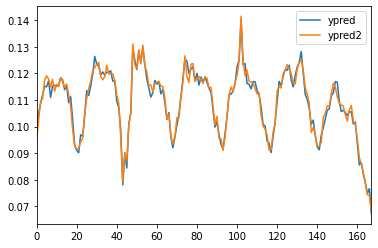

In [19]:
dt0 = train.groupby( ['dt_day','dt_hour'] )['ypred'].agg('mean').reset_index()
dt1 = valid.groupby( ['dt_day','dt_hour'] )['ypred'].agg('mean').reset_index()
dt0.sort_values(['dt_day','dt_hour'], inplace=True)
dt1.sort_values(['dt_day','dt_hour'], inplace=True)

dt0['ypred2'] = dt1['ypred'].values

dt0[['ypred','ypred2']].plot(  )

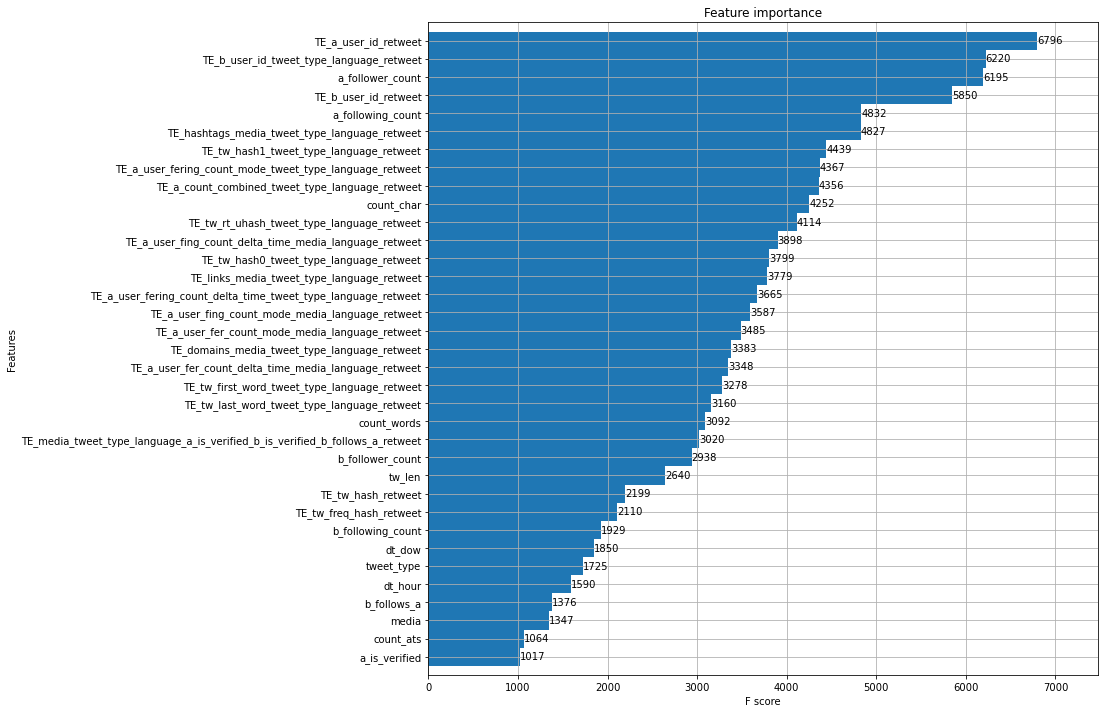

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)

model = joblib.load( 'model-'+TARGET+'-1.xgb' )
plot_importance(model, height=1.0, show_values=True)

# Public val.tsv

In [21]:
test0.sort_values( 'id', inplace=True )
sub = pd.read_csv('../preprocessings/sample_submission_public.csv')

In [22]:
test0.head()

,hashtags,tweet_id,media,links,domains,tweet_type,language,timestamp,a_user_id,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_user_id,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a,reply,retweet,retweet_comment,like,id,tr,dt_day,dt_dow,dt_hour,a_count_combined,a_user_fer_count_delta_time,a_user_fing_count_delta_time,a_user_fering_count_delta_time,a_user_fing_count_mode,a_user_fer_count_mode,a_user_fering_count_mode,count_ats,count_char,count_words,tw_hash,tw_freq_hash,tw_first_word,tw_second_word,tw_last_word,tw_llast_word,tw_len,tw_hash0,tw_hash1,tw_rt_uhash,TE_b_user_id_tweet_type_language_retweet,TE_tw_first_word_tweet_type_language_retweet,TE_tw_last_word_tweet_type_language_retweet,TE_tw_hash0_tweet_type_language_retweet,TE_tw_hash1_tweet_type_language_retweet,TE_tw_rt_uhash_tweet_type_language_retweet,TE_a_user_id_retweet,TE_b_user_id_retweet,TE_tw_hash_retweet,TE_tw_freq_hash_retweet,TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_retweet,TE_a_count_combined_tweet_type_language_retweet,TE_a_user_fer_count_delta_time_media_language_retweet,TE_a_user_fing_count_delta_time_media_language_retweet,TE_a_user_fering_count_delta_time_tweet_type_language_retweet,TE_a_user_fing_count_mode_media_language_retweet,TE_a_user_fer_count_mode_media_language_retweet,TE_a_user_fering_count_mode_tweet_type_language_retweet,TE_domains_media_tweet_type_language_retweet,TE_links_media_tweet_type_language_retweet,TE_hashtags_media_tweet_type_language_retweet
121386431,0,57733249,5,0,0,2,54,1581703126,534117,13919,1214,0,1448292186,3617447,8794,2134,0,1520948869,1,0,0,0,0,121386431,1,14,4,17,6,1,1,1,0,1,1,0,55,5,38691181,34413698,562265,296463,83986,110811,3,0,0,0,NaN,0.122519,0.127419,0.096040,0.095944,0.096044,0.064392,0.091062,NaN,NaN,0.122908,0.174686,0.155413,0.110555,0.171882,0.009589,0.147760,0.165577,0.088073,0.088073,0.070502
121386432,0,57733250,7,0,0,1,47,1582021842,2721240,186,100,0,1263078566,12365145,111835,3,0,1335110299,0,0,0,0,0,121386432,1,18,1,10,-9,-9,-9,-9,-9,-9,-9,0,57,5,38691182,34413699,7376000,4871859,348771,1398132,2,0,0,102048,0.104071,NaN,0.070500,0.108894,0.104526,0.070500,0.099340,0.099546,NaN,NaN,0.134671,0.092170,0.131169,0.131169,0.092170,0.131169,0.131169,0.092170,0.127259,0.127259,0.122412
121386433,0,57733251,1,0,0,2,13,1581734918,2023199,249849,1,0,1356488269,28952089,249849,1,0,1503940711,0,0,0,0,0,121386433,1,15,5,2,0,0,1,0,1,0,0,0,49,5,38691183,18372275,16591,29975,1205,23578,2,0,0,0,NaN,0.080944,0.036425,0.105246,0.114281,0.105234,0.063710,NaN,NaN,0.104071,0.199067,0.000434,0.005346,0.224013,0.002643,0.219285,0.006178,0.003689,0.178308,0.178308,0.118749
121386434,0,57733252,7,0,0,1,54,1581913613,2816974,517,407,0,1449096567,13774342,574475,2656,0,1396311956,1,0,0,0,0,121386434,1,17,0,4,2,1,1,1,1,1,1,0,104,16,38691184,34413700,7376001,165976,4845,16174,7,0,0,2446,0.113767,NaN,0.091928,0.119549,0.112607,0.138078,0.068296,0.099546,NaN,NaN,0.143886,0.269482,0.193622,0.164088,0.265449,0.159599,0.188355,0.243212,0.126007,0.126007,0.126332
121386435,0,57733253,5,0,0,2,54,1581565745,366629,19578,273,1,1236181798,11208153,218811,4980,0,1298646801,0,0,0,0,0,121386435,1,13,3,3,0,0,1,0,1,0,0,0,82,10,38691185,34413701,4769376,56375,852,51742,3,0,0,0,NaN,0.080944,0.060050,0.096040,0.095944,0.096044,0.052190,NaN,NaN,NaN,0.056582,0.000171,0.001266,0.110555,0.000644,0.104499,0.003411,0.003184,0.088073,0.088073,0.070502


In [23]:
dtest = xgb.DMatrix(data=test0.drop(RMV, axis=1))

In [24]:
model = joblib.load( 'model-'+TARGET+'-1.xgb')
ytest = model.predict(dtest,ntree_limit=500)
del model; gc.collect()
len(ytest)

12434735

In [25]:
model = joblib.load( 'model-'+TARGET+'-2.xgb' )
ytest += model.predict(dtest)
ytest /= 2.
del model, dtest; gc.collect()
len(ytest)

12434735

In [26]:
test0['ypred'] = ytest

print( test0.groupby('dt_day')['ypred'].mean() )
m17 = test0.loc[ (test0.dt_day==17)&(test0.dt_hour==23), 'ypred' ].mean()
m18a = test0.loc[ (test0.dt_day==18)&(test0.dt_hour==0), 'ypred' ].mean()
m18b = test0.loc[ (test0.dt_day==18)&(test0.dt_hour==23), 'ypred' ].mean()
m19 = test0.loc[ (test0.dt_day==19)&(test0.dt_hour==0), 'ypred' ].mean()

print( m17, m18a, m18b, m19, m17/m18a, m19/m18b,0.5*m17/m18a+ 0.5*m19/m18b )

dt_day
13    0.101950
14    0.102981
15    0.100704
16    0.100838
17    0.107496
18    0.140063
19    0.093540
Name: ypred, dtype: float32
0.097273864 0.13671198 0.12802711 0.097728975 0.71152407 0.76334596 0.73743498827292


In [27]:
test0.loc[ test0.dt_day==18 ,'ypred'] *=  ( 0.5*m17/m18a+ 0.5*m19/m18b )

sub['prediction'] = test0['ypred'].values
sub.to_csv('submissions/xgb-final-'+TARGET+'-public-1.csv',header=None, index=False)
sub['prediction'].mean()

0.10170355

# Private competition_test.tsv

In [28]:
test1.sort_values( 'id', inplace=True )
sub = pd.read_csv('../preprocessings/sample_submission_private.csv')

In [29]:
test1.head()

,hashtags,tweet_id,media,links,domains,tweet_type,language,timestamp,a_user_id,a_follower_count,a_following_count,a_is_verified,a_account_creation,b_user_id,b_follower_count,b_following_count,b_is_verified,b_account_creation,b_follows_a,reply,retweet,retweet_comment,like,id,tr,dt_day,dt_dow,dt_hour,a_count_combined,a_user_fer_count_delta_time,a_user_fing_count_delta_time,a_user_fering_count_delta_time,a_user_fing_count_mode,a_user_fer_count_mode,a_user_fering_count_mode,count_ats,count_char,count_words,tw_hash,tw_freq_hash,tw_first_word,tw_second_word,tw_last_word,tw_llast_word,tw_len,tw_hash0,tw_hash1,tw_rt_uhash,TE_b_user_id_tweet_type_language_retweet,TE_tw_first_word_tweet_type_language_retweet,TE_tw_last_word_tweet_type_language_retweet,TE_tw_hash0_tweet_type_language_retweet,TE_tw_hash1_tweet_type_language_retweet,TE_tw_rt_uhash_tweet_type_language_retweet,TE_a_user_id_retweet,TE_b_user_id_retweet,TE_tw_hash_retweet,TE_tw_freq_hash_retweet,TE_media_tweet_type_language_a_is_verified_b_is_verified_b_follows_a_retweet,TE_a_count_combined_tweet_type_language_retweet,TE_a_user_fer_count_delta_time_media_language_retweet,TE_a_user_fing_count_delta_time_media_language_retweet,TE_a_user_fering_count_delta_time_tweet_type_language_retweet,TE_a_user_fing_count_mode_media_language_retweet,TE_a_user_fer_count_mode_media_language_retweet,TE_a_user_fering_count_mode_tweet_type_language_retweet,TE_domains_media_tweet_type_language_retweet,TE_links_media_tweet_type_language_retweet,TE_hashtags_media_tweet_type_language_retweet
133821166,0,66410929,0,0,0,2,11,1581759640,12167358,119,125,0,1571666822,6237935,189,264,0,1478011810,1,0,0,0,0,133821166,2,15,5,9,2,1,1,1,1,1,1,0,59,15,45410185,40509199,163328,11867,5615,8175,5,0,0,0,0.080944,0.016900,0.043753,0.065124,0.068161,0.065125,0.099340,0.078053,NaN,NaN,0.035084,0.113329,0.135183,0.102979,0.113108,0.097863,0.128083,0.109425,0.036662,0.036662,0.042429
133821167,25339,66410930,0,0,0,1,11,1581668217,9371104,189,264,0,1575966890,6237935,189,264,0,1478011810,1,0,0,0,0,133821167,2,14,4,8,2,1,1,1,1,1,1,0,189,36,43004406,38346818,4631037,288783,808,902,11,0,0,3665864,NaN,0.138499,0.095718,0.113657,0.110866,NaN,0.095021,0.078053,NaN,NaN,0.149485,0.272158,0.135183,0.102979,0.268963,0.097863,0.128083,0.249861,0.119008,0.119008,0.050825
133821168,0,66410931,9,0,0,1,54,1582046459,199258,4312,660,0,1494251627,879586,4312,660,0,1540395738,1,0,0,0,0,133821168,2,18,1,17,-9,-9,-9,-9,-9,-9,-9,0,129,18,45410186,40509200,7627046,1151943,2638,18369,8,0,0,139857,0.144795,NaN,0.066836,0.119549,0.112607,0.181900,0.085385,0.306183,NaN,NaN,0.131317,0.097242,0.106691,0.106691,0.097242,0.106691,0.106691,0.097242,0.116451,0.116451,0.115911
133821169,26906,66410932,5,0,0,1,4,1582083666,924614,272,185,0,1559086871,647103,272,185,0,1432084055,1,0,0,0,0,133821169,2,19,2,3,2,1,1,1,1,1,1,0,73,9,39837068,35471058,6610718,1008990,69708,35969,3,0,0,364477,NaN,NaN,0.123103,0.268123,0.259497,NaN,0.147141,0.152514,NaN,NaN,0.305488,0.504703,0.319379,0.253471,0.500458,0.249619,0.311038,0.478840,0.243152,0.243152,0.084057
133821170,518727,66410933,5,0,0,1,54,1581779241,4280276,1020,2097,0,1468438879,29849501,405774,974,0,1385502405,0,0,0,0,0,133821170,2,15,5,15,10,-1,-1,-1,-1,-1,-1,5,167,24,45410187,40509201,7773604,5355936,3030,2103,9,6521258,5953099,325751,NaN,NaN,0.097428,NaN,NaN,0.095021,0.091062,NaN,NaN,NaN,0.088363,0.050882,0.048713,0.068570,0.032003,0.070561,0.062146,0.034965,0.095762,0.095762,NaN


In [30]:
dtest = xgb.DMatrix(data=test1.drop(RMV, axis=1))

In [31]:
model = joblib.load( 'model-'+TARGET+'-1.xgb' )
ytest = model.predict(dtest)
del model; gc.collect()
len(ytest)

12434838

In [32]:
model = joblib.load( 'model-'+TARGET+'-2.xgb' )
ytest += model.predict(dtest)
ytest /= 2.
del model, dtest; gc.collect()
len(ytest)

12434838

In [33]:
test1['ypred'] = ytest

print( test1.groupby('dt_day')['ypred'].mean() )

m17 = test1.loc[ (test1.dt_day==17)&(test1.dt_hour==23), 'ypred' ].mean()
m18a = test1.loc[ (test1.dt_day==18)&(test1.dt_hour==0), 'ypred' ].mean()
m18b = test1.loc[ (test1.dt_day==18)&(test1.dt_hour==23), 'ypred' ].mean()
m19 = test1.loc[ (test1.dt_day==19)&(test1.dt_hour==0), 'ypred' ].mean()
print( m17, m18a, m18b, m19, m17/m18a, m19/m18b, 0.5*m17/m18a+ 0.5*m19/m18b )

dt_day
13    0.102074
14    0.102373
15    0.100582
16    0.100219
17    0.107195
18    0.139616
19    0.093376
Name: ypred, dtype: float32
0.096610755 0.13723531 0.12949888 0.097543165 0.70397884 0.7532356 0.7286071944218901


In [34]:
test1.loc[ test1.dt_day==18 ,'ypred'] *= ( 0.5*m17/m18a+ 0.5*m19/m18b )

sub['prediction'] = test1['ypred'].values
sub.to_csv('submissions/xgb-'+TARGET+'-private-1.csv',header=None, index=False)
sub['prediction'].mean()

0.101237535

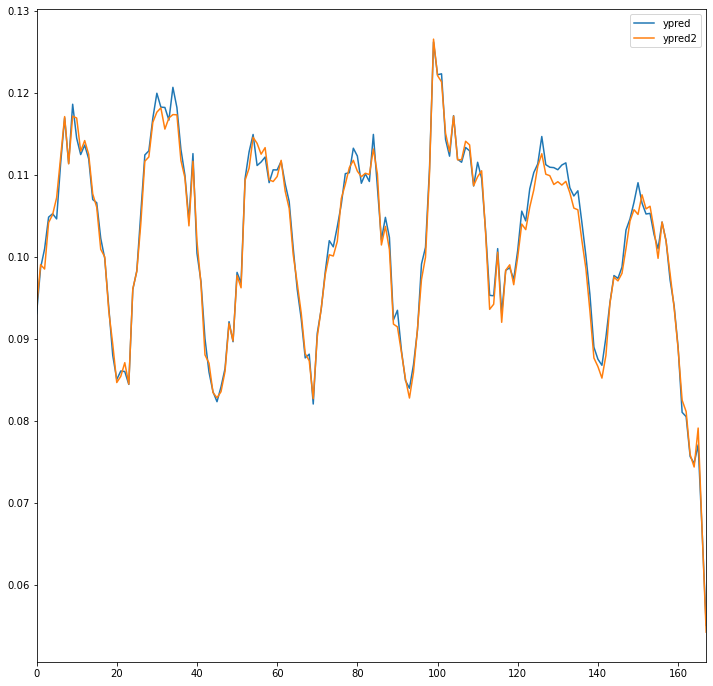

In [35]:
dt0 = test0.groupby( ['dt_day','dt_hour'] )['ypred'].agg('mean').reset_index()
dt1 = test1.groupby( ['dt_day','dt_hour'] )['ypred'].agg('mean').reset_index()
dt0.sort_values(['dt_day','dt_hour'], inplace=True)
dt1.sort_values(['dt_day','dt_hour'], inplace=True)

dt0['ypred2'] = dt1['ypred'].values

dt0[['ypred','ypred2']].plot(  )

In [36]:
print('Elapsed Time is %f minutes'%((time.time()-startNB)/60))

Elapsed Time is 45.681281 minutes
